In [85]:
# convert SSE data files to format: date	open	high	low	close	volume	tic	day
import pandas as pd

df = pd.read_csv('../data/train/SSE.csv')
df_test = pd.read_csv('../data/test/SSE_test.csv')

# concat
df = pd.concat([df, df_test], axis=0)

# date
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
# rename
df = df.rename(columns={'trade_date':'date', 'ts_code':'tic', 'vol':'volume'})

# cal week day
df['day'] = df['date'].dt.dayofweek

# drop
df = df.drop(columns=['pre_close', 'change', 'pct_chg', 'amount'])

# save
df.to_csv('datasets/SSE.csv', index=False)

# Get China's A share stock price data

In [119]:
# 使用tushare 下载数据

import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")
# 设置token
ts.set_token('4167d168dd2c182108319b0f5fc93d66b21d5ccf2baa2af2a522b80d')
pro = ts.pro_api()

# Train 5 years, Test 2 years
train_start_date='2016-01-01'
train_stop_date='2021-01-01'
test_start_date='2021-01-01'
test_stop_date='2023-01-01'

# get ticket lits in 上证50
# 获取上证50成分股
index_weight_df = pro.index_weight(index_code='000016.SH', start_date=train_start_date, end_date=test_stop_date)
ticket_list = index_weight_df.pivot_table(index="trade_date", columns="con_code", values="weight").dropna(axis=1).columns


In [87]:
data_df = pd.DataFrame()
# 获取daily数据
for ticket in ticket_list:
    df = pro.daily(ts_code=ticket, start_date=train_start_date, end_date=test_stop_date)
    # date
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
    df = df.sort_values(by='trade_date', ascending=True)
    df = df.reset_index(drop=True)
    # rename
    df = df.rename(columns={'trade_date':'date', 'ts_code':'tic', 'vol':'volume'})
    # cal week day
    df['day'] = df['date'].dt.dayofweek

    # 缺失值处理
    df = df.fillna(method='ffill')

    # drop
    df = df.drop(columns=['pre_close', 'change', 'pct_chg', 'amount'])
    data_df = data_df.append(df)
    df.to_csv(f'datasets/ChinaA15/{ticket}.csv', index=False)

# data_df.to_csv('datasets/ChinaA15.csv', index=False)

In [88]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.config import (
    INDICATORS,
)
# reload(FeatureEngineer)
import importlib
import sys
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
importlib.reload(sys.modules['finrl.meta.preprocessor.preprocessors'])
from finrl.meta.preprocessor.preprocessors import FeatureEngineer


fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)
print(data_df.shape)
data_df.fillna('ffill', inplace=True)
processed = fe.preprocess_data(data_df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)


(28834, 8)
Successfully added technical indicators
Successfully added turbulence index


In [89]:
processed.sample(5)

,tic,date,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
2267,601857.SH,2016-10-14,7.28,7.30,7.26,7.30,172254.56,4,-0.023542,7.413172,7.148828,48.506532,-39.559925,7.570456,7.344000,7.333333,0.000000
12760,601288.SH,2020-05-19,3.40,3.41,3.39,3.40,897599.79,1,-0.003883,3.449187,3.376813,47.103937,-58.707124,0.597706,3.412000,3.414500,2.108314
17759,601857.SH,2022-01-28,5.23,5.27,4.99,5.02,2900570.98,4,0.045437,5.596588,4.859412,47.806029,-13.429835,5.791304,5.126667,4.998167,20.754039
18427,601601.SH,2022-04-27,20.09,20.59,19.91,20.38,302168.07,2,-0.849139,24.250524,20.488476,33.247092,-251.135130,58.464505,22.548333,24.593500,22.153829
4597,600036.SH,2017-07-31,25.64,25.95,25.38,25.57,341959.65,0,0.766270,26.529384,22.932616,62.233502,100.333672,32.518600,24.185000,22.694667,5.912744


In [90]:
# add turnover_rate and pb

df_pb = pd.DataFrame()
for tic in processed.tic.unique():
    df_pb = df_pb.append(
        pro.daily_basic(ts_code=tic,
                        start_date=train_start_date,
                        end_date=test_stop_date,
                        fields='ts_code,trade_date,turnover_rate,pb'))
# rename trade_date to date, ts_code to tic
df_pb = df_pb.rename(columns={'trade_date':'date', 'ts_code':'tic'})
# date
df_pb['date'] = pd.to_datetime(df_pb['date'], format='%Y%m%d')
# concate 
processed = pd.merge(processed, df_pb, on=['date', 'tic'], how='left')
print(processed.shape)
print(processed.isnull().sum())
processed.sample(5)

(20436, 19)
tic              0
date             0
open             0
high             0
low              0
close            0
volume           0
day              0
macd             0
boll_ub          0
boll_lb          0
rsi_30           0
cci_30           0
dx_30            0
close_30_sma     0
close_60_sma     0
turbulence       0
turnover_rate    0
pb               0
dtype: int64


,tic,date,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,turnover_rate,pb
6202,601688.SH,2018-02-09,17.46,17.78,16.40,16.88,1138897.34,4,-0.358844,22.124876,17.508124,36.926008,-186.758307,47.186111,19.530000,19.202500,67.597143,2.0921,1.4071
1016,601628.SH,2016-05-10,20.46,20.57,20.17,20.26,72733.17,1,-0.560123,24.184010,20.328990,38.013906,-184.554560,45.833174,22.704667,22.310167,0.000000,0.0349,1.8206
7405,600036.SH,2018-07-16,26.17,26.58,25.58,25.67,359321.94,0,-0.653669,29.112165,24.211835,40.151424,-71.794872,34.237324,27.374667,28.345167,10.556142,0.1742,1.4684
17232,600028.SH,2021-11-29,4.02,4.07,4.02,4.06,1096271.52,0,-0.055139,4.178090,4.043910,44.005937,-83.750000,14.477336,4.197667,4.342000,3.281510,0.1147,0.6389
18068,601628.SH,2022-03-14,25.80,25.96,25.58,25.65,64751.98,0,-0.957034,32.082519,25.217481,34.648211,-181.281819,59.705578,28.783667,29.365167,11.155149,0.0311,1.5398


In [91]:
processed.to_csv('datasets/ChinaA15_processed.csv', index=False)

In [94]:
index_weight_df.pivot_table(index="trade_date", columns="con_code", values="weight").dropna(axis=1)

con_code,600028.SH,600030.SH,600036.SH,600048.SH,600104.SH,600519.SH,600887.SH,601088.SH,601166.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601668.SH,601688.SH,601857.SH
trade_date,,,,,,,,,,,,,,,,,
20160129,1.376,3.410,4.620,1.680,1.840,3.013,2.418,0.792,5.763,3.416,9.770,2.643,2.186,1.018,2.299,1.423,1.083
20160229,1.386,3.408,4.553,1.777,1.838,3.274,2.389,0.818,5.734,3.465,9.528,2.635,2.241,1.004,2.333,1.350,1.072
20160331,1.365,3.821,4.526,1.633,1.810,3.394,2.410,0.759,5.649,3.336,9.398,2.524,2.249,1.084,2.332,1.524,1.008
20160429,1.410,3.564,5.042,1.591,1.853,3.476,2.510,0.806,5.921,3.285,9.559,2.531,2.390,0.995,2.276,1.566,0.993
20160531,1.385,3.606,5.065,1.495,1.831,3.626,2.550,0.753,5.895,3.327,9.671,2.566,2.340,0.983,2.247,1.647,0.977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220831,0.829,2.765,6.295,1.803,1.049,17.536,2.655,1.452,3.610,1.320,6.891,2.228,1.041,0.742,1.564,1.122,0.753
20220930,0.881,2.611,6.395,1.985,1.026,18.058,2.593,1.602,3.718,1.402,6.916,2.341,1.068,0.809,1.658,1.095,0.765
20221031,0.950,2.932,5.794,1.730,1.122,14.801,2.256,1.614,3.815,1.538,6.835,2.539,1.137,0.773,1.739,1.230,0.812


# 加入weight到数据processed

In [96]:
# 2020-08-01 2021-10-01
rebalance_window = 63
validation_window = 63
unique_trade_date = processed[(processed.date > '2020-08-01')&(processed.date <= '2021-10-01')].date.unique()
print(unique_trade_date.shape)
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

(285,)
Sharpe Ratio:  0.6792020685148145


In [122]:
index_weight_df.drop(columns=['index_code'], inplace=True)
# rename
index_weight_df = index_weight_df.rename(columns={'trade_date':'date', 'con_code':'tic'})
# date
index_weight_df['date'] = pd.to_datetime(index_weight_df['date'], format='%Y%m%d')
# select
index_weight_df = index_weight_df[index_weight_df['tic'].isin(ticket_list)]


In [134]:
# index_weight_df 根据date计算 month_year
index_weight_df['month_year'] = pd.to_datetime(index_weight_df['date']).dt.to_period('M')
# 去除 -
index_weight_df['month_year'] = index_weight_df['month_year'].astype(str).str.replace('-','')


,tic,date,weight,month_year
2,600519.SH,2022-12-30,16.242,202212
6,601668.SH,2022-12-30,1.705,202212
8,600036.SH,2022-12-30,6.905,202212
10,601088.SH,2022-12-30,1.364,202212
14,601688.SH,2022-12-30,0.982,202212
...,...,...,...,...
4190,600030.SH,2016-01-29,3.410,201601
4193,601318.SH,2016-01-29,9.770,201601
4194,600104.SH,2016-01-29,1.840,201601
4197,601601.SH,2016-01-29,2.186,201601


In [143]:
# 根据 month_year 合并 processed 和 index_weight_df，只保留index_weight_df中的 weight
merged_processed = pd.merge(processed, index_weight_df[['tic', 'month_year', 'weight']], on=['tic', 'month_year'], how='left')


In [130]:
# processed的date有多少个月
processed['month'] = processed['date'].dt.month
processed['year'] = processed['date'].dt.year
processed['month_year'] = processed['date'].dt.to_period('M')
processed['month_year'] = processed['month_year'].astype(str)
processed['month_year'] = processed['month_year'].apply(lambda x: x.replace('-',''))
processed['month_year'] = processed['month_year'].astype(int)
processed['month_year'] = processed['month_year'].astype(str)
processed['month_year'] = processed['month_year'].apply(lambda x: x[:6])


In [148]:
# 计算每一天的weight和
merged_processed['weight_sum'] = merged_processed.groupby(['date'])['weight'].transform('sum')
# 计算每只股票每一天的weight占比
merged_processed['close_weighted'] = merged_processed['close'] * merged_processed['weight']/merged_processed['weight_sum']

In [153]:
processed_mean

,close_weighted,date
date,,
2016-01-04,35.883017,2016-01-04
2016-01-05,36.300676,2016-01-05
2016-01-06,36.337474,2016-01-06
2016-01-07,34.766212,2016-01-07
2016-01-08,35.184795,2016-01-08
...,...,...
2022-12-26,691.982345,2022-12-26
2022-12-27,688.816966,2022-12-27
2022-12-28,689.057057,2022-12-28


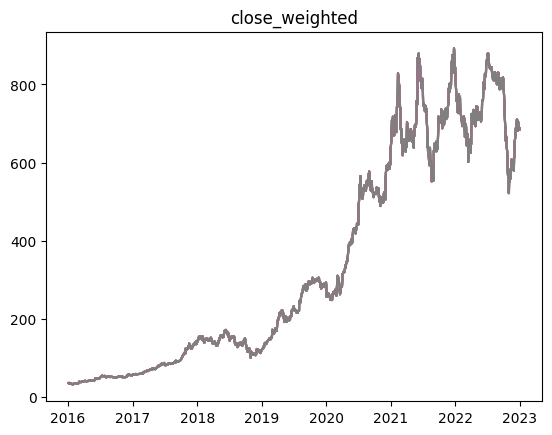

In [159]:
# 画图
%matplotlib inline
processed_mean = merged_processed.groupby('date')[['close_weighted']].sum()
processed_mean['date'] = pd.to_datetime(processed_mean.index)
# plt.plot(processed_mean.date, processed_mean.close_weighted)
# plot close_weighted
plt.plot(processed_mean.date, processed_mean.close_weighted)
# save 
# plt.savefig('close_weighted.png')
plt.show()


In [121]:
tmp = index_weight_df.copy()
# rename date
tmp = tmp.rename(columns={'trade_date':'date'})
tmp['date'] = pd.to_datetime(tmp['date'], format='%Y%m%d')
tmp

,index_code,con_code,date,weight
0,000016.SH,600406.SH,2022-12-30,1.223
1,000016.SH,601225.SH,2022-12-30,1.079
2,000016.SH,600519.SH,2022-12-30,16.242
3,000016.SH,600010.SH,2022-12-30,0.655
4,000016.SH,600809.SH,2022-12-30,2.082
...,...,...,...,...
4195,000016.SH,601988.SH,2016-01-29,2.028
4196,000016.SH,601336.SH,2016-01-29,0.688
4197,000016.SH,601601.SH,2016-01-29,2.186
4198,000016.SH,600519.SH,2016-01-29,3.013


In [127]:
index_weight_df

,tic,date,weight
2,600519.SH,2022-12-30,16.242
6,601668.SH,2022-12-30,1.705
8,600036.SH,2022-12-30,6.905
10,601088.SH,2022-12-30,1.364
14,601688.SH,2022-12-30,0.982
...,...,...,...
4190,600030.SH,2016-01-29,3.410
4193,601318.SH,2016-01-29,9.770
4194,600104.SH,2016-01-29,1.840
4197,601601.SH,2016-01-29,2.186
